In [11]:
%matplotlib inline

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import datetime, timedelta
import gdal
import scipy as sp

import cartopy.crs as ccrs

In [12]:
s_time = datetime(2018,5,9,0)
e_time = datetime(2018,5,12,23)

# Tasmania
lon0 = 144 
lon1 = 149
lat0 = -40
lat1 = -44
res = 0.05

In [13]:
# path for HIMAWARI (after running Pablos algorthim to stack nc files)
path_him = '/g/data1a/oe9/user/data/himawari/TAS/HIM8_TAS_20180509T0000-20180512T2300.nc'
path_awap = '/g/data1a/oe9/user/data/gridded_rainfall_0.05deg/rain_day_2018_Actual_day.nc'

In [14]:
him = xr.open_dataset(path_him)

In [15]:
him.time.values

array([20180509.        , 20180509.04166667, 20180509.08333333,
       20180509.125     , 20180509.16666667, 20180509.20833333,
       20180509.25      , 20180509.29166667, 20180509.33333333,
       20180509.375     , 20180509.41666667, 20180509.45833333,
       20180509.5       , 20180509.54166667, 20180509.58333333,
       20180509.625     , 20180509.66666667, 20180509.70833333,
       20180509.75      , 20180509.79166667, 20180509.83333333,
       20180509.875     , 20180509.91666667, 20180509.95833333,
       20180510.        , 20180510.04166667, 20180510.08333333,
       20180510.125     , 20180510.16666667, 20180510.20833333,
       20180510.25      , 20180510.29166667, 20180510.33333333,
       20180510.375     , 20180510.41666667, 20180510.45833333,
       20180510.5       , 20180510.54166667, 20180510.58333333,
       20180510.625     , 20180510.66666667, 20180510.70833333,
       20180510.75      , 20180510.79166667, 20180510.83333333,
       20180510.875     , 20180510.91666

In [16]:
him['f1'] = (him['B14']<=230)
him['f2'] = (him['B8']-him['B14'])>= -10
him['mask_n'] = him['f1']*1 + him['f2']*1

In [17]:
him['f3'] = (him['B8']-him['B10'])>= -7
him['f4'] = (him['B16']-him['B14'])>= -5
him['mask_n'] = him['mask_n']*1 + him['f3']*1 + him['f4']*1

In [18]:
him['f5'] = (him['B15']-him['B14'])>= -1.5
him['f6'] = (him['B11']-him['B14'])>= 2
him['mask_n'] = him['mask_n']*1 + him['f5']*1 + him['f6']*1

In [19]:
him['f7'] = (((him['B8']+him['B13'])/2)-273) <= -35
him['mask_n'] = him['mask_n'] + him['f7']*1

In [20]:
him['mask']= him['mask_n']>=5

In [22]:
him2 = him.copy()
him2.time.values = np.floor(him2.time)
index_time = np.unique(him2.time.values, return_index=True)
him3=him2[['mask']].isel(time = index_time[1]).copy()

lat = him3['lat'].values
lon = him3['lon'].values
time = him3['time'].values

for ii in np.arange(len(him3.time.values)):    
    mask = np.any(np.stack(him2['mask'].sel(time=him3.time.values[ii]).values),axis = 0)
    if ii==0:
        mask_all = mask.copy()
        mask_all = np.expand_dims(mask_all,axis=0)
    else:
        mask = np.expand_dims( mask,axis=0)
        mask_all= np.append( mask_all,mask,axis=0)

him4 = xr.Dataset({'mask': (['time', 'lat', 'lon'],  mask_all)},coords={ 'lon': lon, 'lat': lat, 'time': time})

In [23]:
# make mask cmap
mask_cmap = colors.ListedColormap(['#FFFFFF','#A9A9A9'])
bounds=np.arange(-1, 1, 2).tolist()

def plotter(arr,ii):
    plt.figure(figsize=(4,4))
    ax = plt.axes(projection=ccrs.PlateCarree())
    #ax.set_title("%02i/%02i/%04i %02i:%02i:%02iUTC"%(dates[ii].day,dates[ii].month,dates[ii].year,dates[ii].hour,dates[ii].minute,dates[ii].second))
    img_extent = (lon0,lon1,lat1,lat0)
    ax.coastlines(linewidth=2,resolution='50m')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    ax.add_feature(states_provinces, edgecolor='black')
    ax.set_xticks([i for i in np.arange(lon0,lon1+1,1)],crs=ccrs.PlateCarree())
    ax.set_yticks([i for i in np.arange(lat1,lat0+1,1)],crs=ccrs.PlateCarree())
    ax.set_xlabel("Longitude $(^\circ)$")
    ax.set_ylabel("Latitude $(^\circ)$")
    im=ax.imshow(arr.isel(time=i), origin='upper', extent=img_extent, cmap=mask_cmap, transform=ccrs.PlateCarree())

In [30]:
awap= xr.open_dataset(path_awap)
awap = awap.sel(time = slice(s_time+timedelta(days=1),e_time+timedelta(days=1)),latitude = slice(lat0,lat1),longitude= slice(lon0,lon1))
awap['rain_day'].isel(time=0)

<xarray.DataArray 'rain_day' (latitude: 81, longitude: 101)>
array([[14.601562, 14.398438, 14.5     , ...,       nan,       nan,       nan],
       [17.898438, 16.601562, 14.5     , ...,       nan,       nan,       nan],
       [17.296875, 16.398438,       nan, ...,       nan,       nan,       nan],
       ...,
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan],
       [      nan,       nan,       nan, ...,       nan,       nan,       nan]],
      dtype=float32)
Coordinates:
    time       datetime64[ns] 2018-05-10
  * latitude   (latitude) float64 -40.0 -40.05 -40.1 ... -43.9 -43.95 -44.0
  * longitude  (longitude) float64 144.0 144.1 144.1 144.2 ... 148.9 148.9 149.0
Attributes:
    name:           rain_day
    standard_name:  lwe_thickness_of_precipitation_amount
    long_name:      Daily Rainfall
    units:          mm

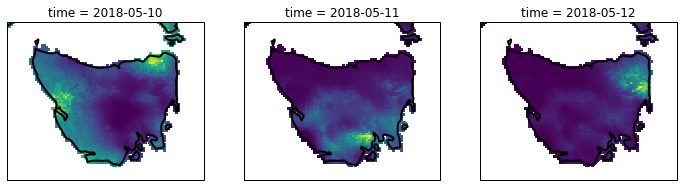

In [31]:
fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 3) # plot 3 axes along one row with three columns

# add first axis
ax1 = fig.add_subplot(gs[0, 0],projection=ccrs.PlateCarree())
awap['rain_day'].isel(time=0).plot(ax=ax1,transform=ccrs.PlateCarree(),add_colorbar=False) # don't plot colorbar
ax1.coastlines(linewidth=2,resolution='50m'); ax1.set_extent([lon0,lon1,lat1,lat0])

# add second axis
ax2 = fig.add_subplot(gs[0, 1],projection=ccrs.PlateCarree())
awap['rain_day'].isel(time=1).plot(ax=ax2,transform=ccrs.PlateCarree(),add_colorbar=False)
ax2.coastlines(linewidth=2,resolution='50m'); ax2.set_extent([lon0,lon1,lat1,lat0])

# add second axis
ax3 = fig.add_subplot(gs[0, 2],projection=ccrs.PlateCarree())
awap['rain_day'].isel(time=2).plot(ax=ax3,transform=ccrs.PlateCarree(),add_colorbar=False)
ax3.coastlines(linewidth=2,resolution='50m'); ax3.set_extent([lon0,lon1,lat1,lat0])

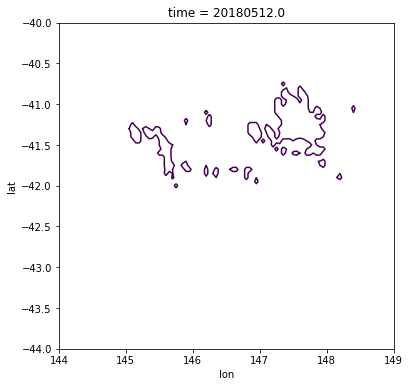

In [32]:
awap_lat = awap['latitude'].data
awap_lon = awap['longitude'].data

him4['mask']=him4['mask']*1
mask_resamp = him4.mask.interp(lat = awap_lat, lon = awap_lon)
mask_resamp.isel(time=3).plot.contour(levels=1,figsize=(6,6))

In [33]:
# resample mask
awap_lat = awap['latitude'].data
awap_lon = awap['longitude'].data
him4['mask']=him4['mask']*1
mask_resamp = him4.mask.interp(lat = awap_lat, lon = awap_lon)

In [34]:
# make mask cmap
mask_cmap = colors.ListedColormap(['#FFFFFF00','#A9A9A940'])
bounds=np.arange(-1, 1, 2).tolist()
import cartopy.feature as cfeature
def plot_timestep(i):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection=ccrs.PlateCarree())
    awap['rain_day'].isel(time=i).plot(ax=ax,transform=ccrs.PlateCarree(),cmap="Blues",\
                                   norm=colors.LogNorm(vmin=1,vmax=50),cbar_kwargs={"shrink":0.7}) # don't plot colorbar
    mask_resamp.isel(time=i).plot(ax=ax,transform=ccrs.PlateCarree(),cmap=mask_cmap,add_colorbar=False)
    mask_resamp.isel(time=i).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=1,colors="grey",linewidths=0.5)

    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    ax.add_feature(states_provinces, edgecolor='black')
    ax.coastlines(linewidth=1,resolution='50m')
    ax.set_extent([lon0,lon1,lat1,lat0])
    ax.set_xticks([i for i in np.arange(lon0,lon1,1)],crs=ccrs.PlateCarree())
    ax.set_yticks([i for i in np.arange(lat1,lat0,1)],crs=ccrs.PlateCarree())
    ax.set_xlabel("Longitude $(^\circ)$")
    ax.set_ylabel("Latitude $(^\circ)$")

mkdir: cannot create directory `tas_anim/': File exists
0


/g/data/oe9/software/miniconda3/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


1
2
3


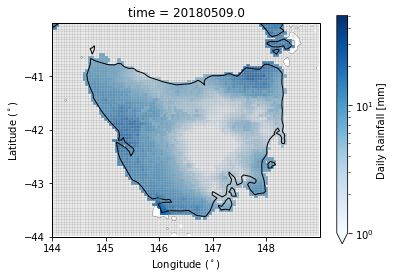

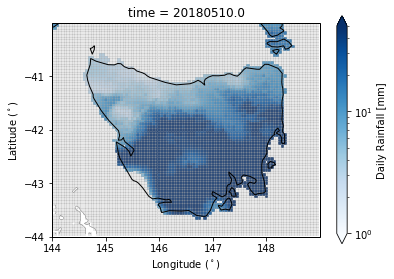

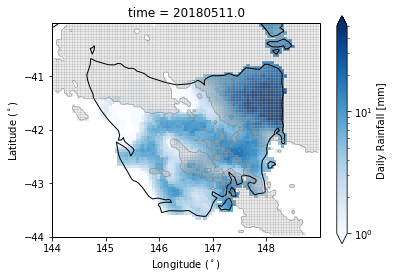

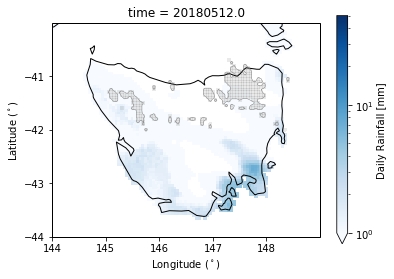

In [35]:
!mkdir tas_anim/
for i in range(len(mask_resamp['time'].values)):
    print(i)
    plot_timestep(i)
    fname = "tas_anim/%03i_mask.png"%i
    plt.savefig(fname)

In [36]:
# resize image to cut off white space, then animate
#!mogrify -extent 430x350 -gravity Center tas_anim/*_f4.png
!convert -delay 25 tas_anim/*_mask.png -delay 200 $fname -loop 0 Tasmania_mask_awap.gif

In [ ]:
him['B8'].sel(time=0).plot()